In [1]:
from __future__ import print_function, division
import os
import sys
import datetime

sys.path.insert(0,os.path.expanduser("deepfish"))
from deepfish.deep_skip import DeepSkip, train
Model = DeepSkip

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
# import apex # https://github.com/NVIDIA/apex.git
# from apex.amp import amp


import os, sys, datetime
import itertools
# LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
# FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
# FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
# sys.path.insert(0,LF_CODE_PATH)
# sys.path.insert(0,FT_CODE_PATH)
# sys.path.insert(0,FD_CODE_PATH)

# import passivity_2p_imaging_utils as p2putils
# reload(p2putils)
tmp_dir = '/tmp/'
# all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

# sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half

T.backends.cudnn.benchmark = True

# PARAMETERS
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
kl_lambda = 5e-4
sparse_lambda=1e-3
lr=1e-3
nepochs = 8
nEmbedding = 20
# batch_size = 6
batch_size = 32

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
class ZebraFishDataRNA(Dataset):
    "B x nFrames x Z x H x W"
    def __init__(self, imaging, structural, shocks, tail_movements,
                 index_map=None, prev_frames=2, next_frames=1):
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.shocks = shocks
        self.tail_movements = tail_movements
        self.index_map = index_map
        self.structural = structural

    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        "X[0]==X_i, X[1]==X_i-1, Y[0]==Y_i+1, Y[1]==Y_i+2"
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        X = {"brain": [], "shock": [], "tail_movement": []}
        Y = {"brain": [], "shock": [], "tail_movement": []}
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            X["brain"].append(self.data[ix])
            X["shock"].append(self.shocks[ix])
            X["tail_movement"].append(self.tail_movements[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            Y["brain"].append(self.data[ix])
            Y["shock"].append(self.shocks[ix])
            Y["tail_movement"].append(self.tail_movements[ix])
        for s in structural:
            X["brain"].append(s)
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y


In [3]:
from tifffile import imread
from glob import glob
import re

In [4]:
directory = "/data2/Data/f10542/"

In [5]:
get_num = re.compile(".*_zplane=(\d*).npy")
get_z = lambda x: int(get_num.search(x).group(1))
get_strucural = re.compile(".*[gcamp|gad|vglut].npy")
# planes = glob(directory+"functional*.npy")
structural = glob(directory+"cnmf/*.npy")
# structural = list(filter(lambda x: get_num.match(x) is None, structural))
structural = list(filter(lambda x: get_strucural.match(x) is not None, structural))
# planes = sorted(planes, key=lambda a: get_z(a))
# nZ = len(planes)
# print(f"Number of planes: {nZ}")
structural

['/data2/Data/f10542/cnmf/functional.npy',
 '/data2/Data/f10542/cnmf/isosbestic_gcamp.npy',
 '/data2/Data/f10542/cnmf/postfix_gcamp.npy',
 '/data2/Data/f10542/cnmf/postfix_gad.npy',
 '/data2/Data/f10542/cnmf/postfix_vglut.npy']

In [6]:
imaging = np.load(directory+"cnmf/functional.npy")
isosbestic_gcamp = np.load(structural[1])
postfix_gcamp = np.load(structural[2])
postfix_gad = np.load(structural[3])
postfix_vglut = np.load(structural[4])

structural = T.from_numpy(np.stack([isosbestic_gcamp, postfix_gcamp, postfix_gad, postfix_vglut]))
structural.shape

torch.Size([4, 29, 256, 256])

In [7]:
postfix_vglut.shape

(29, 256, 256)

In [8]:
mean_frame = imaging.mean(0)

nT, nZ, H, W = imaging.shape
nT, nZ, H, W

(5437, 29, 256, 256)

In [9]:
shocks = T.from_numpy(np.zeros(nT).astype(np.float32))
tail_movements = T.from_numpy(np.zeros(nT).astype(np.float32))

In [10]:
# tvt_split = train_valid_test_split(2826, nchunks=20)
tvt_split = train_test_split(nT, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])


# LOAD TIFF
train_data = ZebraFishData(imaging, shocks,tail_movements,
# train_data = ZebraFishDataRNA(imaging,structural, shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

# test_data = ZebraFishDataRNA(imaging,structural,shocks,tail_movements,
test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

# all_data = ZebraFishData(imaging,shocks,tail_movements,None,
#                         prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape


# print("Number of tail movements in test: {}".format(np.array([float(x[1]["tail_movement"]) for x in test_data]).sum()))


# print("len(train_data): {}".format(len(train_data)))

# print("len(test_data): {}".format(len(test_data)))

['train: 4868 (96.05%)', 'validation: 0 (0.00%)', 'test: 200 (3.95%)']


In [11]:
del imaging

In [12]:
gc.collect()

22

In [13]:
from __future__ import print_function, division
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from volume import Vol2D
from resnet import ResNet, BasicBlock
from super_res import SuperResSkip
from torch.utils.data import DataLoader, Dataset
from misc import sigmoid_schedule
from tqdm import tqdm



class DeepSkip(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(DeepSkip, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 16
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 64
        self.nEmbedding = nEmbedding
        assert nEmbedding % 2 == 0

        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.nhalf_embed = int(self.nEmbedding/2)
        # Prediction
        self.pred1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Prediction
        self.predz1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.predz2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(self.nhalf_embed,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResSkip(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResSkip(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResSkip(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResSkip(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResSkip(2,tensor)
        # 11 x 256 x 512

        self.tail_decoding = nn.Linear(1,1)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)

    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        x = x.transpose(1,2)
        # X :: b x z x t x h x w
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
#                 print("layer_out "+k+" shape: "+ str(layer_out[k].shape))
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs

    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x

    def predictZero(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.predz1(x))
        x = self.predz2(x)
        return x

    def decode(self, x, layer_output):
        tail = T.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
#         tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail

    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_prev = self.predictZero(encoded[:,self.nhalf_embed:], shock)
        encoded_pred = self.predict(encoded[:,:self.nhalf_embed], shock)
        prev = self.decode(encoded_prev, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?

def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)

    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        i = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0 and i < 100:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
                i += 1
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)

        avg_Y_loss = cum_Y_loss/len(train_data)
        avg_X_loss = cum_X_loss/len(train_data)
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), avg_X_loss, avg_Y_loss, cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))
#         cum_loss = 0
#         cum_X_loss = 0
#         cum_Y_loss = 0
#         cum_kld_loss = 0
#         cum_tail_loss = 0
#         model.eval()
#         gc.collect()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
#             if half:
#                 X_pred = X_pred.float()
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             kld = unit_norm_KL_divergence(mean, logvar)
#             mse_X = F.mse_loss(X_pred, Y[:,0])
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
#             loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
#             cum_loss += float(loss)
#             cum_X_loss += float(mse_X)
#             cum_Y_loss += float(mse_Y)
#             cum_kld_loss += float(kld)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_loss, avg_Y_loss, avg_Y_valid_loss


def validation_loss(model,valid_data, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    cum_loss = 0
    cum_X_loss = 0
    cum_Y_loss = 0
    cum_kld_loss = 0
    cum_tail_loss = 0
    with T.no_grad():
        model.eval()
        for batch_data in tqdm(valid_dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda * kld + kl_tail*mse_tail
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)
    model.train()
    avg_Y_valid_loss = cum_Y_loss/len(valid_data)
    avg_X_valid_loss = cum_X_loss/len(valid_data)
    print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
    cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_valid_loss, avg_Y_valid_loss


In [17]:
batch_size = 8
multi_gpu = True

tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

# conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames + len(structural),next_frames, tensor=tensor)
conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames,next_frames, tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 1420430


conv_model.load_state_dict(T.load("/data2/trained_models/"+
#                                   "190113_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}.pt"))
#     "190112_f15042_notail_nostructure_epoch=12_xloss=1.11E+2_yloss=1.29E+2.pt"))
                                  "190114_f15042_notail_gad_vglut_cnmf_folder_epoch=4_xloss=1.255E+02_yloss=1.452E+02.pt"))


avg_X_valid_loss, avg_Y_valid_loss = validation_loss(conv_model,test_data, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

In [23]:
avg_X_valid_loss, avg_Y_valid_loss = validation_loss(conv_model,test_data, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)
# good is ~1.1 for X and ~1.25? for Y




  0%|          | 0/25 [00:00<?, ?it/s]


  4%|▍         | 1/25 [00:04<01:43,  4.31s/it]


  8%|▊         | 2/25 [00:05<01:16,  3.34s/it]


 12%|█▏        | 3/25 [00:06<00:57,  2.63s/it]


 16%|█▌        | 4/25 [00:07<00:45,  2.15s/it]


 20%|██        | 5/25 [00:08<00:36,  1.80s/it]


 24%|██▍       | 6/25 [00:09<00:29,  1.57s/it]


 28%|██▊       | 7/25 [00:10<00:25,  1.41s/it]


 32%|███▏      | 8/25 [00:11<00:21,  1.29s/it]


 36%|███▌      | 9/25 [00:12<00:19,  1.21s/it]


 40%|████      | 10/25 [00:13<00:17,  1.16s/it]


 44%|████▍     | 11/25 [00:14<00:16,  1.15s/it]


 48%|████▊     | 12/25 [00:15<00:14,  1.14s/it]


 52%|█████▏    | 13/25 [00:16<00:13,  1.11s/it]


 56%|█████▌    | 14/25 [00:17<00:11,  1.09s/it]


 60%|██████    | 15/25 [00:18<00:10,  1.07s/it]


 64%|██████▍   | 16/25 [00:19<00:09,  1.06s/it]


 68%|██████▊   | 17/25 [00:20<00:08,  1.06s/it]


 72%|███████▏  | 18/25 [00:22<00:07,  1.05s/it]


 76%|███████▌  | 19/25 [00:23<00:06,  1.05s/it]


 80%|████████  

VALIDATION: avg_loss: 2.730346E+02, X_loss: 1.249415E+02, Y_loss: 1.462217E+02, KLD: 4.022110E+00, tail_loss: 1.867435E-02


In [18]:
# WARNING: TEST DATA BEING USED AS VALIDATION (turned off for now...)
avg_X_loss, avg_Y_loss, avg_Y_valid_loss = train(conv_model,train_data,test_data,nepochs,lr=lr, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)


T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

model_name = f"/data2/trained_models/" + \
    f"190114_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}"

T.save(conv_model.state_dict(),
       model_name+".pt")



  0%|          | 0/609 [00:00<?, ?it/s]

epoch 0: MSE_X: 1.486E+03, MSE_Y: 1.445E+03, KLD: 5.539E+01, Tail: 3.682E-01




  0%|          | 1/609 [00:16<2:47:00, 16.48s/it]

MSE_X: 1.539E+03, MSE_Y: 1.542E+03, KLD: 1.209E+02, Tail: 2.666E-01




  0%|          | 2/609 [00:23<2:18:58, 13.74s/it]

MSE_X: 1.419E+03, MSE_Y: 1.437E+03, KLD: 2.946E+02, Tail: 2.099E-01




  0%|          | 3/609 [00:26<1:45:48, 10.48s/it]

MSE_X: 1.390E+03, MSE_Y: 1.380E+03, KLD: 5.559E+02, Tail: 1.840E-01




  1%|          | 4/609 [00:29<1:22:31,  8.18s/it]

MSE_X: 1.346E+03, MSE_Y: 1.519E+03, KLD: 8.736E+02, Tail: 1.581E-01




  1%|          | 5/609 [00:32<1:06:58,  6.65s/it]

MSE_X: 1.472E+03, MSE_Y: 1.485E+03, KLD: 1.224E+03, Tail: 1.412E-01




  1%|          | 6/609 [00:35<55:31,  5.53s/it]  

MSE_X: 1.380E+03, MSE_Y: 1.324E+03, KLD: 1.603E+03, Tail: 1.285E-01




  1%|          | 7/609 [00:38<47:23,  4.72s/it]

MSE_X: 1.386E+03, MSE_Y: 1.409E+03, KLD: 1.985E+03, Tail: 1.187E-01




  1%|▏         | 8/609 [00:41<42:03,  4.20s/it]

MSE_X: 1.367E+03, MSE_Y: 1.358E+03, KLD: 2.414E+03, Tail: 1.102E-01




  1%|▏         | 9/609 [00:44<38:18,  3.83s/it]

MSE_X: 1.499E+03, MSE_Y: 1.459E+03, KLD: 2.856E+03, Tail: 1.036E-01




  2%|▏         | 10/609 [00:47<35:19,  3.54s/it]

MSE_X: 1.561E+03, MSE_Y: 1.697E+03, KLD: 3.352E+03, Tail: 9.931E-02




  2%|▏         | 11/609 [00:50<33:13,  3.33s/it]

MSE_X: 1.480E+03, MSE_Y: 1.548E+03, KLD: 3.842E+03, Tail: 9.376E-02




  2%|▏         | 12/609 [00:52<31:49,  3.20s/it]

MSE_X: 1.446E+03, MSE_Y: 1.415E+03, KLD: 4.405E+03, Tail: 8.792E-02




  2%|▏         | 13/609 [00:55<31:03,  3.13s/it]

MSE_X: 1.279E+03, MSE_Y: 1.291E+03, KLD: 4.979E+03, Tail: 8.098E-02




  2%|▏         | 14/609 [00:58<30:11,  3.04s/it]

MSE_X: 1.355E+03, MSE_Y: 1.405E+03, KLD: 5.624E+03, Tail: 7.424E-02




  2%|▏         | 15/609 [01:01<29:54,  3.02s/it]

MSE_X: 1.371E+03, MSE_Y: 1.390E+03, KLD: 6.242E+03, Tail: 7.033E-02




  3%|▎         | 16/609 [01:04<29:20,  2.97s/it]

MSE_X: 1.367E+03, MSE_Y: 1.362E+03, KLD: 6.972E+03, Tail: 6.799E-02




  3%|▎         | 17/609 [01:07<29:06,  2.95s/it]

MSE_X: 1.483E+03, MSE_Y: 1.520E+03, KLD: 7.549E+03, Tail: 6.617E-02




  3%|▎         | 18/609 [01:10<28:47,  2.92s/it]

MSE_X: 1.355E+03, MSE_Y: 1.344E+03, KLD: 8.277E+03, Tail: 6.423E-02




  3%|▎         | 19/609 [01:13<28:51,  2.93s/it]

MSE_X: 1.376E+03, MSE_Y: 1.359E+03, KLD: 8.959E+03, Tail: 6.230E-02




  3%|▎         | 20/609 [01:16<28:34,  2.91s/it]

MSE_X: 1.395E+03, MSE_Y: 1.414E+03, KLD: 9.612E+03, Tail: 6.049E-02




  3%|▎         | 21/609 [01:19<28:50,  2.94s/it]

MSE_X: 1.506E+03, MSE_Y: 1.645E+03, KLD: 1.022E+04, Tail: 5.888E-02




  4%|▎         | 22/609 [01:21<28:12,  2.88s/it]

MSE_X: 1.328E+03, MSE_Y: 1.383E+03, KLD: 1.083E+04, Tail: 5.744E-02




  4%|▍         | 23/609 [01:24<28:08,  2.88s/it]

MSE_X: 1.454E+03, MSE_Y: 1.419E+03, KLD: 1.134E+04, Tail: 5.614E-02




  4%|▍         | 24/609 [01:27<27:57,  2.87s/it]

MSE_X: 1.367E+03, MSE_Y: 1.374E+03, KLD: 1.185E+04, Tail: 5.490E-02




  4%|▍         | 25/609 [01:30<27:53,  2.86s/it]

MSE_X: 1.342E+03, MSE_Y: 1.403E+03, KLD: 1.237E+04, Tail: 5.372E-02




  4%|▍         | 26/609 [01:33<27:46,  2.86s/it]

MSE_X: 1.356E+03, MSE_Y: 1.406E+03, KLD: 1.274E+04, Tail: 5.258E-02




  4%|▍         | 27/609 [01:36<27:37,  2.85s/it]

MSE_X: 1.370E+03, MSE_Y: 1.358E+03, KLD: 1.315E+04, Tail: 5.148E-02




  5%|▍         | 28/609 [01:38<27:19,  2.82s/it]

MSE_X: 1.342E+03, MSE_Y: 1.363E+03, KLD: 1.350E+04, Tail: 5.041E-02




  5%|▍         | 29/609 [01:41<27:19,  2.83s/it]

MSE_X: 1.324E+03, MSE_Y: 1.360E+03, KLD: 1.380E+04, Tail: 4.936E-02




  5%|▍         | 30/609 [01:44<27:35,  2.86s/it]

MSE_X: 1.265E+03, MSE_Y: 1.315E+03, KLD: 1.413E+04, Tail: 4.835E-02




  5%|▌         | 31/609 [01:47<27:27,  2.85s/it]

MSE_X: 1.414E+03, MSE_Y: 1.438E+03, KLD: 1.438E+04, Tail: 4.735E-02




  5%|▌         | 32/609 [01:50<27:19,  2.84s/it]

MSE_X: 1.387E+03, MSE_Y: 1.409E+03, KLD: 1.456E+04, Tail: 4.638E-02




  5%|▌         | 33/609 [01:53<27:16,  2.84s/it]

MSE_X: 1.398E+03, MSE_Y: 1.435E+03, KLD: 1.478E+04, Tail: 4.543E-02




  6%|▌         | 34/609 [01:55<27:13,  2.84s/it]

MSE_X: 1.309E+03, MSE_Y: 1.340E+03, KLD: 1.494E+04, Tail: 4.450E-02




  6%|▌         | 35/609 [01:58<27:11,  2.84s/it]

MSE_X: 1.258E+03, MSE_Y: 1.291E+03, KLD: 1.510E+04, Tail: 4.360E-02




  6%|▌         | 36/609 [02:01<27:13,  2.85s/it]

MSE_X: 1.358E+03, MSE_Y: 1.371E+03, KLD: 1.521E+04, Tail: 4.271E-02




  6%|▌         | 37/609 [02:04<27:49,  2.92s/it]

MSE_X: 1.393E+03, MSE_Y: 1.384E+03, KLD: 1.531E+04, Tail: 4.185E-02




  6%|▌         | 38/609 [02:07<27:34,  2.90s/it]

MSE_X: 1.511E+03, MSE_Y: 1.542E+03, KLD: 1.538E+04, Tail: 4.100E-02




  6%|▋         | 39/609 [02:10<27:34,  2.90s/it]

MSE_X: 1.303E+03, MSE_Y: 1.334E+03, KLD: 1.543E+04, Tail: 4.018E-02




  7%|▋         | 40/609 [02:13<27:26,  2.89s/it]

MSE_X: 1.378E+03, MSE_Y: 1.406E+03, KLD: 1.545E+04, Tail: 3.937E-02




  7%|▋         | 41/609 [02:16<27:36,  2.92s/it]

MSE_X: 1.348E+03, MSE_Y: 1.392E+03, KLD: 1.550E+04, Tail: 3.859E-02




  7%|▋         | 42/609 [02:19<27:20,  2.89s/it]

MSE_X: 1.269E+03, MSE_Y: 1.291E+03, KLD: 1.552E+04, Tail: 3.782E-02




  7%|▋         | 43/609 [02:22<27:17,  2.89s/it]

MSE_X: 1.378E+03, MSE_Y: 1.480E+03, KLD: 1.550E+04, Tail: 3.707E-02




  7%|▋         | 44/609 [02:24<27:06,  2.88s/it]

MSE_X: 1.223E+03, MSE_Y: 1.278E+03, KLD: 1.543E+04, Tail: 3.633E-02




  7%|▋         | 45/609 [02:27<27:17,  2.90s/it]

MSE_X: 1.316E+03, MSE_Y: 1.408E+03, KLD: 1.539E+04, Tail: 3.562E-02




  8%|▊         | 46/609 [02:30<26:54,  2.87s/it]

MSE_X: 1.342E+03, MSE_Y: 1.400E+03, KLD: 1.532E+04, Tail: 3.492E-02




  8%|▊         | 47/609 [02:33<26:47,  2.86s/it]

MSE_X: 1.290E+03, MSE_Y: 1.308E+03, KLD: 1.525E+04, Tail: 3.424E-02




  8%|▊         | 48/609 [02:36<27:13,  2.91s/it]

MSE_X: 1.415E+03, MSE_Y: 1.509E+03, KLD: 1.518E+04, Tail: 3.357E-02




  8%|▊         | 49/609 [02:39<27:19,  2.93s/it]

MSE_X: 1.292E+03, MSE_Y: 1.392E+03, KLD: 1.509E+04, Tail: 3.292E-02




  8%|▊         | 50/609 [02:42<27:00,  2.90s/it]

MSE_X: 1.240E+03, MSE_Y: 1.269E+03, KLD: 1.495E+04, Tail: 3.228E-02




  8%|▊         | 51/609 [02:45<26:37,  2.86s/it]

MSE_X: 1.246E+03, MSE_Y: 1.306E+03, KLD: 1.486E+04, Tail: 3.166E-02




  9%|▊         | 52/609 [02:47<26:16,  2.83s/it]

MSE_X: 1.230E+03, MSE_Y: 1.268E+03, KLD: 1.469E+04, Tail: 3.106E-02




  9%|▊         | 53/609 [02:50<26:27,  2.85s/it]

MSE_X: 1.279E+03, MSE_Y: 1.302E+03, KLD: 1.455E+04, Tail: 3.047E-02




  9%|▉         | 54/609 [02:53<26:26,  2.86s/it]

MSE_X: 1.208E+03, MSE_Y: 1.264E+03, KLD: 1.441E+04, Tail: 2.989E-02




  9%|▉         | 55/609 [02:56<26:11,  2.84s/it]

MSE_X: 1.249E+03, MSE_Y: 1.301E+03, KLD: 1.429E+04, Tail: 2.933E-02




  9%|▉         | 56/609 [02:59<26:10,  2.84s/it]

MSE_X: 1.237E+03, MSE_Y: 1.259E+03, KLD: 1.418E+04, Tail: 2.878E-02




  9%|▉         | 57/609 [03:02<26:25,  2.87s/it]

MSE_X: 1.217E+03, MSE_Y: 1.244E+03, KLD: 1.409E+04, Tail: 2.825E-02




 10%|▉         | 58/609 [03:05<26:08,  2.85s/it]

MSE_X: 1.165E+03, MSE_Y: 1.248E+03, KLD: 1.394E+04, Tail: 2.772E-02




 10%|▉         | 59/609 [03:07<26:08,  2.85s/it]

MSE_X: 1.225E+03, MSE_Y: 1.337E+03, KLD: 1.386E+04, Tail: 2.721E-02




 10%|▉         | 60/609 [03:10<26:03,  2.85s/it]

MSE_X: 1.265E+03, MSE_Y: 1.280E+03, KLD: 1.376E+04, Tail: 2.671E-02




 10%|█         | 61/609 [03:13<26:00,  2.85s/it]

MSE_X: 1.214E+03, MSE_Y: 1.448E+03, KLD: 1.363E+04, Tail: 2.622E-02




 10%|█         | 62/609 [03:16<25:56,  2.84s/it]

MSE_X: 1.261E+03, MSE_Y: 1.291E+03, KLD: 1.350E+04, Tail: 2.575E-02




 10%|█         | 63/609 [03:19<26:08,  2.87s/it]

MSE_X: 1.259E+03, MSE_Y: 1.345E+03, KLD: 1.336E+04, Tail: 2.529E-02




 11%|█         | 64/609 [03:22<26:23,  2.91s/it]

MSE_X: 1.337E+03, MSE_Y: 1.358E+03, KLD: 1.328E+04, Tail: 2.483E-02




 11%|█         | 65/609 [03:25<26:13,  2.89s/it]

MSE_X: 1.368E+03, MSE_Y: 1.409E+03, KLD: 1.315E+04, Tail: 2.439E-02




 11%|█         | 66/609 [03:27<25:53,  2.86s/it]

MSE_X: 1.360E+03, MSE_Y: 1.451E+03, KLD: 1.301E+04, Tail: 2.396E-02




 11%|█         | 67/609 [03:30<25:51,  2.86s/it]

MSE_X: 1.412E+03, MSE_Y: 1.445E+03, KLD: 1.291E+04, Tail: 2.354E-02




 11%|█         | 68/609 [03:33<25:38,  2.84s/it]

MSE_X: 1.313E+03, MSE_Y: 1.418E+03, KLD: 1.280E+04, Tail: 2.312E-02




 11%|█▏        | 69/609 [03:36<26:02,  2.89s/it]

MSE_X: 1.227E+03, MSE_Y: 1.282E+03, KLD: 1.270E+04, Tail: 2.272E-02




 11%|█▏        | 70/609 [03:39<25:54,  2.88s/it]

MSE_X: 1.216E+03, MSE_Y: 1.234E+03, KLD: 1.259E+04, Tail: 2.233E-02




 12%|█▏        | 71/609 [03:42<25:45,  2.87s/it]

MSE_X: 1.171E+03, MSE_Y: 1.232E+03, KLD: 1.243E+04, Tail: 2.194E-02




 12%|█▏        | 72/609 [03:45<25:38,  2.87s/it]

MSE_X: 1.190E+03, MSE_Y: 1.252E+03, KLD: 1.238E+04, Tail: 2.157E-02




 12%|█▏        | 73/609 [03:48<25:33,  2.86s/it]

MSE_X: 1.427E+03, MSE_Y: 1.384E+03, KLD: 1.228E+04, Tail: 2.120E-02




 12%|█▏        | 74/609 [03:50<25:18,  2.84s/it]

MSE_X: 1.259E+03, MSE_Y: 1.310E+03, KLD: 1.222E+04, Tail: 2.085E-02




 12%|█▏        | 75/609 [03:53<25:17,  2.84s/it]

MSE_X: 1.262E+03, MSE_Y: 1.392E+03, KLD: 1.219E+04, Tail: 2.050E-02




 12%|█▏        | 76/609 [03:56<25:17,  2.85s/it]

MSE_X: 1.267E+03, MSE_Y: 1.356E+03, KLD: 1.213E+04, Tail: 2.015E-02




 13%|█▎        | 77/609 [03:59<25:16,  2.85s/it]

MSE_X: 1.249E+03, MSE_Y: 1.292E+03, KLD: 1.206E+04, Tail: 1.982E-02




 13%|█▎        | 78/609 [04:02<25:16,  2.86s/it]

MSE_X: 1.174E+03, MSE_Y: 1.307E+03, KLD: 1.192E+04, Tail: 1.949E-02




 13%|█▎        | 79/609 [04:05<25:03,  2.84s/it]

MSE_X: 1.322E+03, MSE_Y: 1.385E+03, KLD: 1.185E+04, Tail: 1.917E-02




 13%|█▎        | 80/609 [04:07<24:48,  2.81s/it]

MSE_X: 1.337E+03, MSE_Y: 1.376E+03, KLD: 1.175E+04, Tail: 1.886E-02




 13%|█▎        | 81/609 [04:10<24:53,  2.83s/it]

MSE_X: 1.227E+03, MSE_Y: 1.254E+03, KLD: 1.159E+04, Tail: 1.856E-02




 13%|█▎        | 82/609 [04:13<24:50,  2.83s/it]

MSE_X: 1.239E+03, MSE_Y: 1.297E+03, KLD: 1.143E+04, Tail: 1.826E-02




 14%|█▎        | 83/609 [04:16<24:53,  2.84s/it]

MSE_X: 1.215E+03, MSE_Y: 1.364E+03, KLD: 1.126E+04, Tail: 1.797E-02




 14%|█▍        | 84/609 [04:19<24:53,  2.84s/it]

MSE_X: 1.229E+03, MSE_Y: 1.266E+03, KLD: 1.110E+04, Tail: 1.769E-02




 14%|█▍        | 85/609 [04:22<25:15,  2.89s/it]

MSE_X: 1.219E+03, MSE_Y: 1.264E+03, KLD: 1.100E+04, Tail: 1.741E-02




 14%|█▍        | 86/609 [04:25<25:25,  2.92s/it]

MSE_X: 1.181E+03, MSE_Y: 1.249E+03, KLD: 1.091E+04, Tail: 1.714E-02




 14%|█▍        | 87/609 [04:27<24:55,  2.87s/it]

MSE_X: 1.210E+03, MSE_Y: 1.265E+03, KLD: 1.085E+04, Tail: 1.687E-02




 14%|█▍        | 88/609 [04:30<25:09,  2.90s/it]

MSE_X: 1.343E+03, MSE_Y: 1.385E+03, KLD: 1.078E+04, Tail: 1.661E-02




 15%|█▍        | 89/609 [04:33<24:54,  2.87s/it]

MSE_X: 1.188E+03, MSE_Y: 1.248E+03, KLD: 1.069E+04, Tail: 1.635E-02




 15%|█▍        | 90/609 [04:36<24:50,  2.87s/it]

MSE_X: 1.405E+03, MSE_Y: 1.417E+03, KLD: 1.070E+04, Tail: 1.610E-02




 15%|█▍        | 91/609 [04:39<25:02,  2.90s/it]

MSE_X: 1.302E+03, MSE_Y: 1.446E+03, KLD: 1.069E+04, Tail: 1.586E-02




 15%|█▌        | 92/609 [04:42<24:52,  2.89s/it]

MSE_X: 1.305E+03, MSE_Y: 1.327E+03, KLD: 1.068E+04, Tail: 1.562E-02




 15%|█▌        | 93/609 [04:45<24:53,  2.89s/it]

MSE_X: 1.300E+03, MSE_Y: 1.349E+03, KLD: 1.062E+04, Tail: 1.539E-02




 15%|█▌        | 94/609 [04:48<24:44,  2.88s/it]

MSE_X: 1.238E+03, MSE_Y: 1.307E+03, KLD: 1.048E+04, Tail: 1.516E-02




 16%|█▌        | 95/609 [04:51<24:37,  2.87s/it]

MSE_X: 1.267E+03, MSE_Y: 1.324E+03, KLD: 1.035E+04, Tail: 1.493E-02




 16%|█▌        | 96/609 [04:53<24:29,  2.87s/it]

MSE_X: 1.311E+03, MSE_Y: 1.365E+03, KLD: 1.024E+04, Tail: 1.471E-02




 16%|█▌        | 97/609 [04:56<24:42,  2.90s/it]

MSE_X: 1.207E+03, MSE_Y: 1.247E+03, KLD: 1.011E+04, Tail: 1.450E-02




 16%|█▌        | 98/609 [04:59<24:32,  2.88s/it]

MSE_X: 1.232E+03, MSE_Y: 1.293E+03, KLD: 9.990E+03, Tail: 1.429E-02




 16%|█▋        | 99/609 [05:02<24:25,  2.87s/it]

MSE_X: 1.161E+03, MSE_Y: 1.328E+03, KLD: 9.918E+03, Tail: 1.408E-02




 16%|█▋        | 100/609 [05:05<24:18,  2.87s/it]

 17%|█▋        | 101/609 [05:08<24:43,  2.92s/it]

 17%|█▋        | 102/609 [05:11<24:47,  2.93s/it]

 17%|█▋        | 103/609 [05:14<24:31,  2.91s/it]

 17%|█▋        | 104/609 [05:17<24:21,  2.89s/it]

 17%|█▋        | 105/609 [05:20<24:18,  2.89s/it]

 17%|█▋        | 106/609 [05:23<24:25,  2.91s/it]

 18%|█▊        | 107/609 [05:25<24:10,  2.89s/it]

 18%|█▊        | 108/609 [05:28<24:06,  2.89s/it]

 18%|█▊        | 109/609 [05:31<23:57,  2.87s/it]

 18%|█▊        | 110/609 [05:34<23:49,  2.87s/it]

 18%|█▊        | 111/609 [05:37<23:55,  2.88s/it]

 18%|█▊        | 112/609 [05:40<23:45,  2.87s/it]

 19%|█▊        | 113/609 [05:42<23:26,  2.83s/it]

 19%|█▊        | 114/609 [05:45<23:23,  2.84s/it]

 19%|█▉        | 115/609 [05:48<23:20,  2.83s/it]

 19%|█▉        | 116/609 [05:51<23:21,  2.84s/it]

 19%|█▉        | 117/609 [05:54<23:34,  2.87s/it]

 19%|█▉        | 118/609 [05:57<23:20,  2.85s/it]

 20%|█▉        | 119/609 [06:

avg_loss: 2.948254E+02, X_loss: 1.402759E+02, Y_loss: 1.544103E+02, KLD: 8.364130E+02, tail_loss: 1.335582E-03
epoch 1: 



  0%|          | 1/609 [00:12<2:07:59, 12.63s/it]

  0%|          | 2/609 [00:15<1:38:11,  9.71s/it]

  0%|          | 3/609 [00:18<1:17:35,  7.68s/it]

  1%|          | 4/609 [00:21<1:03:16,  6.28s/it]

  1%|          | 5/609 [00:24<53:04,  5.27s/it]  

  1%|          | 6/609 [00:27<45:45,  4.55s/it]

  1%|          | 7/609 [00:30<40:36,  4.05s/it]

  1%|▏         | 8/609 [00:32<36:55,  3.69s/it]

  1%|▏         | 9/609 [00:35<34:41,  3.47s/it]

  2%|▏         | 10/609 [00:38<32:32,  3.26s/it]

  2%|▏         | 11/609 [00:41<31:21,  3.15s/it]

  2%|▏         | 12/609 [00:44<30:48,  3.10s/it]

  2%|▏         | 13/609 [00:47<30:10,  3.04s/it]

  2%|▏         | 14/609 [00:50<29:58,  3.02s/it]

  2%|▏         | 15/609 [00:53<29:53,  3.02s/it]

  3%|▎         | 16/609 [00:56<29:35,  2.99s/it]

  3%|▎         | 17/609 [00:59<29:21,  2.98s/it]

  3%|▎         | 18/609 [01:02<29:01,  2.95s/it]

  3%|▎         | 19/609 [01:05<28:41,  2.92s/it]

  3%|▎         | 20/609 [01:08<28:49,  2.94s/it

avg_loss: 2.738917E+02, X_loss: 1.271166E+02, Y_loss: 1.467667E+02, KLD: 1.590047E+02, tail_loss: 4.730280E-05
epoch 2: 



  0%|          | 1/609 [00:07<1:11:44,  7.08s/it]

  0%|          | 2/609 [00:10<59:03,  5.84s/it]  

  0%|          | 3/609 [00:12<50:14,  4.97s/it]

  1%|          | 4/609 [00:15<44:04,  4.37s/it]

  1%|          | 5/609 [00:18<39:16,  3.90s/it]

  1%|          | 6/609 [00:21<35:59,  3.58s/it]

  1%|          | 7/609 [00:24<33:48,  3.37s/it]

  1%|▏         | 8/609 [00:27<32:05,  3.20s/it]

  1%|▏         | 9/609 [00:30<30:44,  3.07s/it]

  2%|▏         | 10/609 [00:32<29:53,  2.99s/it]

  2%|▏         | 11/609 [00:35<29:42,  2.98s/it]

  2%|▏         | 12/609 [00:38<29:17,  2.94s/it]

  2%|▏         | 13/609 [00:41<29:20,  2.95s/it]

  2%|▏         | 14/609 [00:44<29:05,  2.93s/it]

  2%|▏         | 15/609 [00:47<28:58,  2.93s/it]

  3%|▎         | 16/609 [00:50<28:45,  2.91s/it]

  3%|▎         | 17/609 [00:53<28:40,  2.91s/it]

  3%|▎         | 18/609 [00:55<28:17,  2.87s/it]

  3%|▎         | 19/609 [00:58<28:20,  2.88s/it]

  3%|▎         | 20/609 [01:01<28:12,  2.87s/it]

  3

avg_loss: 2.718273E+02, X_loss: 1.259180E+02, Y_loss: 1.458987E+02, KLD: 1.036054E+02, tail_loss: 2.702707E-05
epoch 3: 



  0%|          | 1/609 [00:07<1:11:36,  7.07s/it]

  0%|          | 2/609 [00:09<58:46,  5.81s/it]  

  0%|          | 3/609 [00:12<49:50,  4.94s/it]

  1%|          | 4/609 [00:15<43:32,  4.32s/it]

  1%|          | 5/609 [00:18<39:30,  3.92s/it]

  1%|          | 6/609 [00:21<36:13,  3.60s/it]

  1%|          | 7/609 [00:24<34:23,  3.43s/it]

  1%|▏         | 8/609 [00:27<32:26,  3.24s/it]

  1%|▏         | 9/609 [00:30<31:25,  3.14s/it]

  2%|▏         | 10/609 [00:33<30:38,  3.07s/it]

  2%|▏         | 11/609 [00:36<30:28,  3.06s/it]

  2%|▏         | 12/609 [00:39<30:21,  3.05s/it]

  2%|▏         | 13/609 [00:42<30:07,  3.03s/it]

  2%|▏         | 14/609 [00:45<29:42,  3.00s/it]

  2%|▏         | 15/609 [00:48<29:44,  3.00s/it]

  3%|▎         | 16/609 [00:51<29:35,  2.99s/it]

  3%|▎         | 17/609 [00:54<29:21,  2.97s/it]

  3%|▎         | 18/609 [00:56<28:59,  2.94s/it]

  3%|▎         | 19/609 [00:59<28:42,  2.92s/it]

  3%|▎         | 20/609 [01:02<28:18,  2.88s/it]

  3

avg_loss: 2.708787E+02, X_loss: 1.254506E+02, Y_loss: 1.454230E+02, KLD: 1.694403E+01, tail_loss: 1.313744E-05
epoch 4: 



  0%|          | 1/609 [00:07<1:11:11,  7.03s/it]

  0%|          | 2/609 [00:09<58:26,  5.78s/it]  

  0%|          | 3/609 [00:12<49:51,  4.94s/it]

  1%|          | 4/609 [00:15<43:47,  4.34s/it]

  1%|          | 5/609 [00:18<39:15,  3.90s/it]

  1%|          | 6/609 [00:21<36:21,  3.62s/it]

  1%|          | 7/609 [00:24<33:58,  3.39s/it]

  1%|▏         | 8/609 [00:27<32:11,  3.21s/it]

  1%|▏         | 9/609 [00:30<31:23,  3.14s/it]

  2%|▏         | 10/609 [00:33<30:28,  3.05s/it]

  2%|▏         | 11/609 [00:35<29:50,  2.99s/it]

  2%|▏         | 12/609 [00:38<29:37,  2.98s/it]

  2%|▏         | 13/609 [00:41<29:26,  2.96s/it]

  2%|▏         | 14/609 [00:44<29:18,  2.96s/it]

  2%|▏         | 15/609 [00:47<29:12,  2.95s/it]

  3%|▎         | 16/609 [00:50<29:09,  2.95s/it]

  3%|▎         | 17/609 [00:53<28:49,  2.92s/it]

  3%|▎         | 18/609 [00:56<28:24,  2.88s/it]

  3%|▎         | 19/609 [00:59<28:40,  2.92s/it]

  3%|▎         | 20/609 [01:02<28:44,  2.93s/it]

  3

avg_loss: 2.702168E+02, X_loss: 1.251752E+02, Y_loss: 1.450360E+02, KLD: 9.033454E+00, tail_loss: 9.853197E-06
epoch 5: 



  0%|          | 1/609 [00:07<1:11:35,  7.06s/it]

  0%|          | 2/609 [00:09<58:53,  5.82s/it]  

  0%|          | 3/609 [00:12<50:04,  4.96s/it]

  1%|          | 4/609 [00:15<43:24,  4.30s/it]

  1%|          | 5/609 [00:18<38:59,  3.87s/it]

  1%|          | 6/609 [00:21<35:49,  3.57s/it]

  1%|          | 7/609 [00:24<33:20,  3.32s/it]

  1%|▏         | 8/609 [00:27<31:52,  3.18s/it]

  1%|▏         | 9/609 [00:29<30:51,  3.09s/it]

  2%|▏         | 10/609 [00:32<30:21,  3.04s/it]

  2%|▏         | 11/609 [00:35<30:06,  3.02s/it]

  2%|▏         | 12/609 [00:38<29:32,  2.97s/it]

  2%|▏         | 13/609 [00:41<29:10,  2.94s/it]

  2%|▏         | 14/609 [00:44<28:38,  2.89s/it]

  2%|▏         | 15/609 [00:47<28:28,  2.88s/it]

  3%|▎         | 16/609 [00:50<28:23,  2.87s/it]

  3%|▎         | 17/609 [00:53<29:09,  2.96s/it]

  3%|▎         | 18/609 [00:56<28:58,  2.94s/it]

  3%|▎         | 19/609 [00:58<28:38,  2.91s/it]

  3%|▎         | 20/609 [01:01<28:43,  2.93s/it]

  3

avg_loss: 2.697750E+02, X_loss: 1.250203E+02, Y_loss: 1.447477E+02, KLD: 7.914411E+00, tail_loss: 8.462958E-06
epoch 6: 



  0%|          | 1/609 [00:07<1:11:52,  7.09s/it]

  0%|          | 2/609 [00:10<59:25,  5.87s/it]  

  0%|          | 3/609 [00:12<50:07,  4.96s/it]

  1%|          | 4/609 [00:15<43:40,  4.33s/it]

  1%|          | 5/609 [00:18<38:58,  3.87s/it]

  1%|          | 6/609 [00:21<35:50,  3.57s/it]

  1%|          | 7/609 [00:24<33:33,  3.34s/it]

  1%|▏         | 8/609 [00:27<31:53,  3.18s/it]

  1%|▏         | 9/609 [00:29<30:51,  3.09s/it]

  2%|▏         | 10/609 [00:32<30:21,  3.04s/it]

  2%|▏         | 11/609 [00:35<29:36,  2.97s/it]

  2%|▏         | 12/609 [00:38<29:14,  2.94s/it]

  2%|▏         | 13/609 [00:41<28:38,  2.88s/it]

  2%|▏         | 14/609 [00:44<28:31,  2.88s/it]

  2%|▏         | 15/609 [00:47<28:23,  2.87s/it]

  3%|▎         | 16/609 [00:49<28:17,  2.86s/it]

  3%|▎         | 17/609 [00:52<28:08,  2.85s/it]

  3%|▎         | 18/609 [00:55<28:31,  2.90s/it]

  3%|▎         | 19/609 [00:58<28:06,  2.86s/it]

  3%|▎         | 20/609 [01:01<28:00,  2.85s/it]

  3

KeyboardInterrupt: 

Process Process-136:
Process Process-138:
Process Process-135:
Process Process-132:
Process Process-133:
Process Process-129:
Process Process-142:
Process Process-130:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/a

In [21]:
model_name = f"/data2/trained_models/" + \
    f"190114_f15042_notail_nostructure_cnmf_folder_epoch=6_xloss=1.250E+02_yloss=1.447E+02"
#     f"190114_f15042_notail_nostructure_cnmf_folder_epoch=6_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}"

In [ ]:
X_loss: 4888E+02, Y_loss: 1.451763E+02

In [27]:
model_name = f"/data2/trained_models/" + \
    f"190114_f15042_notail_gad_vglut_cnmf_folder_epoch=4_xloss=1.255E+02_yloss=1.452E+02"

In [22]:
T.save(conv_model.state_dict(),
       model_name+".pt")

In [22]:
now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)

NameError: name 'f' is not defined

In [ ]:
T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

In [ ]:
avg_X_valid_loss, avg_Y_valid_loss

In [24]:
model_name = f"/data2/trained_models/" + \
    f"190113_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}"

T.save(conv_model.state_dict(),
       model_name+".pt")

NameError: name 'avg_X_loss' is not defined

In [ ]:
model_name

In [ ]:
import skvideo

In [ ]:
mean_frame_T = T.from_numpy(mean_frame).max(0)[0]

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0].max(0)[0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1].max(0)[0] - y[0].max(0)[0])
                frame[H:, W:(2*W)] = np.abs(y_pred.max(0)[0].cpu() - y[0].max(0)[0])
            else:
                frame[:H, W:(2*W)] = y[-1].max(0)[0] - y[0].max(0)[0]
                frame[H:, W:(2*W)] = y_pred.max(0)[0].cpu() - y[0].max(0)[0]
            frame[:H, (2*W):] = y[-1].max(0)[0] + mean_frame_T
            frame[H:, :W] = x_pred.max(0)[0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred.max(0)[0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0][13][0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1][13][0] - y[0][13][0])
                frame[H:, W:(2*W)] = np.abs(y_pred[13][0].cpu() - y[0][13][0])
            else:
                frame[:H, W:(2*W)] = y[-1][13][0] - y[0][13][0]
                frame[H:, W:(2*W)] = y_pred[13][0].cpu() - y[0][13][0]
            frame[:H, (2*W):] = y[-1][13][0] + mean_frame_T
            frame[H:, :W] = x_pred[13][0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred[13][0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [31]:
frame = makePredVideo(conv_model,test_data,
                      T.from_numpy(mean_frame)[13], False,
                      name=model_name+'_demean_z=13_test')

OSError: [Errno 32] Broken pipe

FFMPEG COMMAND:
/home/ubuntu/anaconda3/envs/pytorch_p36/bin/ffmpeg -y -f rawvideo -pix_fmt gray -s 768x512 -i - -b 30000000 -vcodec libx264 /data2/trained_models/190112_f15042_notail_nostructure_epoch=12_xloss=1.11E+2_yloss=1.29E+2_demean_z=13_test.mp4

FFMPEG STDERR OUTPUT:


In [ ]:
plt.imshow(frame)

In [72]:
mymin, mymax

(0.0, 1809.97119140625)

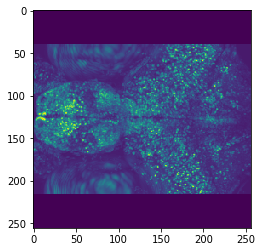

In [74]:
plt.imshow(scale_for_vid(mean_frame_T.numpy(), mymin, mymax))

In [31]:
del imaging